# Flowers
## Image Classification with a pre-trained convolutional neural network in PyTorch

<br>
<br>
Author: Christoph Schauer <br>
Created: 03.08.2019 <br>
Last Update: 04.08.2019

<img src='four_flowers.jpg' width=800px>

## Introduction

This notebook grew out of my course project for the Deep Learning module of [Udacity's Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) that I did some time ago. The dataset used in this project - images of flowers - strikes a good balance between realism and ease-of-use, so I have kept using it for practice. In this notebook, I train a convolutional neural network with PyTorch using a pre-trained model to predict the species of a flower from an image. 

The dataset used for training is the [102 Category Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) by Maria-Elena Nilsback and Andrew Zisserman from the University of Oxford. The dataset contains about 8000 images of 102 species of flowers and can be downloaded from that website as well as from [Kaggle](https://www.kaggle.com/c/oxford-102-flower-pytorch). The data from Kaggle has all images in the training and validation set already in correctly labelled folders; for the images in the test set, that has to be done manually.

After training for just 10 epochs, the model achieves a classification accuracy of about 80% on the test set. Although the dataset is not particularly difficult, that's already pretty good considering that the model has to differentiate between 102 classes and the size of the dataset is not that large.

## Table of Contents

0. Imports
1. Data Loaders and Transforms
2. Network Architecture
3. Training
4. Model Evaluation
5. Saving and Loading Model Checkpoints
6. Predicting the Class of a New Image

## 0. Imports

In [1]:
import time
import json
from collections import OrderedDict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.pyplot import imshow
%matplotlib inline

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

## 1. Data Loaders and Transforms

All pre-trained networks from `torchvision` require images of the size 224x224 pixels. In addition, the means of the images need to be normalized to `[0.485, 0.456, 0.406]` and the the standard deviations need to be normalized to `[0.229, 0.224, 0.225]`.

In [2]:
# Data directories
dir_train = "images_pytorch/train"
dir_valid = "images_pytorch/valid"
dir_test = "images_pytorch/test"

In [3]:
# Transforms for training, validation, testing sets
train_transform = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Datasets
data_train = datasets.ImageFolder(dir_train, transform=train_transform)
data_valid = datasets.ImageFolder(dir_valid, transform=valid_transform)
data_test = datasets.ImageFolder(dir_test, transform=test_transform)

# Dataloaders
batch_size = 16
trainloader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validloader = DataLoader(data_valid, batch_size=batch_size, shuffle= True)
testloader = DataLoader(data_test, batch_size=batch_size)

In [4]:
# Number of batches and classe
batches = len(trainloader.batch_sampler)
num_classes = len(data_train.classes) # 102 classes

In [5]:
# Check data
print("Images in training / validation / test data: {} / {} / {}".format(
    len(trainloader.dataset), len(validloader.dataset), len(testloader.dataset)))
print("Training / validation / test batches: {} / {} / {}".format(
    len(trainloader), len(validloader), len(testloader)))   
print("Classes:", num_classes)

Images in training / validation / test data: 6552 / 818 / 819
Training / validation / test batches: 410 / 52 / 52
Classes: 102


### Mapping classes to flower species

The json file `label_mapping.json` maps the labels (102 classes labelled from '1' to '102') to the real-life names of the flower species.

In [6]:
with open("app/label_mapping.json", "r") as f:
    label_mapping = json.load(f)

In [7]:
# Check data
print("Number of classes:", len(label_mapping))
print(label_mapping)

Number of classes: 102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved p

## 2. Network Architecture

I'm using a network of the VGG family that comes with `torchvision` (see [https://pytorch.org/docs/stable/torchvision/models.html. These models don't perform as well as some of the newer architectures for image classification, but still work well and are pretty straightforward.

In [8]:
# Load the pre-trained VGG16 model from torchvision
model = models.vgg16(pretrained = True)

# Freeze model parameters to prevent backpropagation in the "features" part of the network
# (convolution layers)
for param in model.parameters():
    param.requires_grad = False

# Replace the model "classifier" part of the pre-trained network (fully connected layers) 
# with a custom one for this dataset
input_layer = model.classifier[0].in_features   # number of nodes of the last "features layer"
hidden_layer = [4096, 1024]
output_layer = num_classes

classifier = nn.Sequential(OrderedDict([
    ("0", nn.Linear(input_layer, hidden_layer[0])),
    ("1", nn.ReLU()),
    ("2", nn.Dropout(p=0.25)),
    ("3", nn.Linear(hidden_layer[0], hidden_layer[1])),
    ("4", nn.ReLU()),
    ("5", nn.Dropout(p=0.25)),
    ("6", nn.Linear(hidden_layer[1], output_layer)),
    ("7", nn.LogSoftmax(dim = 1))
]))
model.classifier = classifier

In [9]:
# Check customized model architecture:
print("Customized model architecture:", model)

Customized model architecture: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

## 3. Training

### Train network on cuda-GPU if available

In [10]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Send model to device
model.to(device);

Device: cuda


### Training parameters

In [11]:
num_epochs = 10
learning_rate = 0.001

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Print out training progress every {print_every} batches
print_every = 100 

### Training

In [12]:
# Printouts and visualization --------------------------------------------------

start_time = time.time() 

running_total = 0
running_loss = 0
running_correct = 0
loss_list = [] 

print("Start of training - Device: {} - Epochs: {} - Batches: {} - Batch size: {}"
      .format(device, num_epochs, len(trainloader), batch_size))

# Training ---------------------------------------------------------------------
 
# Set model to training mode
model.train()

# Reset gradients
model.zero_grad()

for epoch in range(num_epochs):       
    for i, (images, labels) in enumerate(trainloader):      

        # Send data to device
        images, labels = images.to(device), labels.to(device)        
        
        # Forward and backward pass
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
# Printouts and visualization --------------------------------------------------
     
        # Store running loss, total predictions, correct predictions, loss
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()         
        loss_list.append(loss.item())
    
        # Print out average training loss and accuracy every {print_every} batches
        if (i+1) % print_every == 0:         
            print("Epoch: {}/{} - TRAINING DATA - Batches: {}/{} - Loss: {:.3f} - Accuracy: {:.3f}".format(
                epoch+1, num_epochs, i+1, len(trainloader), 
                running_loss/print_every, 
                running_correct/running_total))
            
            # Reset running loss and accuracy
            running_loss = 0
            running_total = 0
            running_correct = 0
            
# Evaluate model on validation set ---------------------------------------------

    valid_running_loss = 0
    valid_running_total = 0
    valid_running_correct = 0
        
    # Set model to evaluation mode
    model.eval()
    
    # Turn off gradients
    with torch.no_grad():        
        for i, (images, labels) in enumerate(validloader):
            
            # Send data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)
            
            # Store running loss, total predictions, correct predictions
            valid_running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            valid_running_total += labels.size(0)
            valid_running_correct += (predicted == labels).sum().item()       
       
        print("Epoch: {}/{} - VALIDATION DATA - Loss: {:.3f} - Accuracy {:.3f}".format(
            epoch+1, num_epochs, 
            valid_running_loss/len(validloader),
            valid_running_correct/valid_running_total))
    
    # Set model back to training mode
    model.train()


print("Training complete - Total training time: {:.1f} minutes".format(
    (time.time() - start_time)/60))

Start of training - Device: cuda - Epochs: 10 - Batches: 410 - Batch size: 16
Epoch: 1/10 - TRAINING DATA - Batches: 100/410 - Loss: 4.112 - Accuracy: 0.150
Epoch: 1/10 - TRAINING DATA - Batches: 200/410 - Loss: 2.951 - Accuracy: 0.297
Epoch: 1/10 - TRAINING DATA - Batches: 300/410 - Loss: 2.465 - Accuracy: 0.378
Epoch: 1/10 - TRAINING DATA - Batches: 400/410 - Loss: 2.127 - Accuracy: 0.456
Epoch: 1/10 - VALIDATION DATA - Loss: 1.356 - Accuracy 0.623
Epoch: 2/10 - TRAINING DATA - Batches: 100/410 - Loss: 2.144 - Accuracy: 0.492
Epoch: 2/10 - TRAINING DATA - Batches: 200/410 - Loss: 1.936 - Accuracy: 0.502
Epoch: 2/10 - TRAINING DATA - Batches: 300/410 - Loss: 1.755 - Accuracy: 0.540
Epoch: 2/10 - TRAINING DATA - Batches: 400/410 - Loss: 1.787 - Accuracy: 0.544
Epoch: 2/10 - VALIDATION DATA - Loss: 1.068 - Accuracy 0.687
Epoch: 3/10 - TRAINING DATA - Batches: 100/410 - Loss: 1.809 - Accuracy: 0.578
Epoch: 3/10 - TRAINING DATA - Batches: 200/410 - Loss: 1.671 - Accuracy: 0.568
Epoch: 3/1

### Visualizing training progress

In [13]:
def visualize_training_progress(loss_list):
    '''Visualizes training progress by plotting loss per batch over epochs.'''
    
    plt.figure(figsize=(12,4))
    xticks = np.arange(0, len(loss_list), 100)
    plt.plot(loss_list)
    plt.xticks(xticks)
    plt.xticks(rotation=90)
    plt.xlabel("Batch")
    plt.ylabel("Loss per batch")
    plt.title("Loss per batch over epochs")
    plt.show()

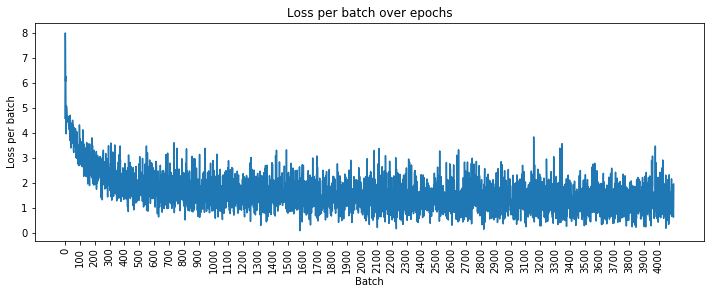

In [14]:
visualize_training_progress(loss_list)

## 4. Model Evaluation

### Loss and accuracy on test set

In [15]:
running_loss = 0
labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Set model to evaluation mode
model.eval()

# Turn off gradients
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        
        # Send data to device
        images, labels = images.to(device), labels.to(device)
    
        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        # Store loss, true labels, predicted labels
        running_loss += loss.item()     
        _, predicted = torch.max(output.data, 1)      
        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

test_accuracy = np.equal(labels_pred, labels_true).mean()         
        
print("Evaluating network on {} images in test set".format(len(testloader.dataset)))
print("Loss: {:.3f} - Accuracy: {:.3f}".format(
    running_loss/len(testloader), test_accuracy))

Evaluating network on 819 images in test set
Loss: 0.698 - Accuracy: 0.812


### Accuracy by class

For many classes, there are only few images in the test data, so take the confusion matrix and accuracy by class with a grain of salt.

In [16]:
# Build confusion matrix
cm = np.zeros((num_classes, num_classes))
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1
    
# Normalize values
for i in range(num_classes):
    cm[i] = cm[i] / cm[i].sum() 

# Accuracy by class 
print(dict(zip(data_train.classes, cm.diagonal())))

{'1': 0.2, '10': 1.0, '100': 0.625, '101': 0.75, '102': 1.0, '11': 1.0, '12': 0.8888888888888888, '13': 0.8333333333333334, '14': 1.0, '15': 0.75, '16': 1.0, '17': 1.0, '18': 0.6666666666666666, '19': 0.7142857142857143, '2': 1.0, '20': 0.6666666666666666, '21': 1.0, '22': 0.75, '23': 1.0, '24': 1.0, '25': 0.6, '26': 0.4, '27': 1.0, '28': 0.8333333333333334, '29': 1.0, '3': 0.5, '30': 0.6428571428571429, '31': 0.5, '32': 0.5, '33': 0.875, '34': 0.6, '35': 0.8333333333333334, '36': 1.0, '37': 0.875, '38': 1.0, '39': 0.4, '4': 0.3333333333333333, '40': 0.25, '41': 1.0, '42': 0.75, '43': 0.8125, '44': 0.9090909090909091, '45': 0.6666666666666666, '46': 1.0, '47': 1.0, '48': 1.0, '49': 0.6666666666666666, '5': 0.75, '50': 1.0, '51': 0.625, '52': 0.875, '53': 0.5714285714285714, '54': 1.0, '55': 0.8571428571428571, '56': 1.0, '57': 0.9090909090909091, '58': 1.0, '59': 1.0, '6': 0.8888888888888888, '60': 1.0, '61': 1.0, '62': 0.75, '63': 1.0, '64': 0.8, '65': 0.8571428571428571, '66': 1.0, '

## 5. Saving and Loading Model Checkpoints

### Save model checkpoint

In [17]:
# Dictionary of the complete model state
model_state = {
    "epoch": num_epochs,   # number of epochs already trained
    "state_dict": model.state_dict(),   # trained weights
    "optimizer_dict": optimizer.state_dict(),   # trained weights
    "classifier": classifier,   # customized fully connected layers
    "class_to_idx": data_train.class_to_idx    # mapping of labels to their indices
}

torch.save(model_state, "app/flower_classifier.pth")
print("Model checkpoint saved")

Model checkpoint saved


### Load model checkpoint

In [18]:
def load_checkpoint(filename):
    '''Loads a saved model checkpoint from a model_state dictionary.'''
    
    # Load model to CPU
    model_state = torch.load(filename, map_location=torch.device("cpu"))
    
    # Load architecture and weights
    model = models.vgg16(pretrained = True)
    model.classifier = model_state["classifier"]
    model.load_state_dict(model_state["state_dict"])
    model.class_to_idx = model_state["class_to_idx"]

    print("Model checkpoint loaded:", filename)
    return model

In [19]:
model = load_checkpoint(filename="app/flower_classifier.pth")
model_name = "flower_classifier"

Model checkpoint loaded: app/flower_classifier.pth


## 6. Predicting the Class of a New Image

### Define functions

In [20]:
def process_image(filename, upload_folder):        
    '''Loads and transform an image for use in a torchvision model.'''
    
    filepath = upload_folder+"/"+filename
    image = Image.open(filepath).convert("RGB")
    
    # Apply transforms
    image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = image_transform(image)
    
    return image

In [21]:
def classify(filename, upload_folder, model=model, model_name=model_name):
    ''' Classifies an image with a PyTorch torchvision model and maps classes 
    (like flower species) from a dictionary to the model classes generated from 
    the image folder names. Returns a dictionary with the name of the classified 
    image and a list of classes and their scores.'''
    
    # Load and transform an image
    image = process_image(filename, upload_folder).unsqueeze(0)

    # Set model to evaluation mode
    model.eval()
    
    # Predict scores
    with torch.no_grad():
        output = model(image)
    
    # Get lists of species and their scores (ordered by the index of the classes)
    species = [label_mapping[k] for k in model.class_to_idx.keys()]
    scores = output.exp().squeeze().tolist()   # exponential because of nllloss   
    class_list = [{"class": species[i], "score": scores[i]} for i in range(len(species))]

    # Wrap everything into a dictionary
    pytorch_output = {
        "image": filename, 
        "classifier": model_name,
        "classes": class_list
        }
        
    return pytorch_output

In [22]:
def predict(filename, upload_folder, model=model, topk=5):
    '''Prints out the top k predicted species and their scores.'''
    
    # Classify image
    pytorch_output = classify(filename, upload_folder)
    
    score_list = pytorch_output["classes"]
    score_list.sort(key=lambda x: x["score"], reverse=True)

    for i in range(topk):
        class_ = score_list[i]["class"]
        score = score_list[i]["score"]
        print("Class: {} - Score: {:.3f}".format(class_, score))

In [23]:
def visualize(filename, upload_folder, model=model, model_name=model_name, topk=5):
    '''Visualizes the top k predicted classes and scores of an image and 
    displays the image.'''
    
    # Classify image
    pytorch_output = classify(filename, upload_folder)
    
    # Get top k classes and scores
    score_list = pytorch_output["classes"]
    score_list.sort(key=lambda x: x["score"], reverse=True)
    
    top_classes = [score_list[i]["class"] for i in range(topk)]
    top_scores = [score_list[i]["score"] for i in range(topk)]

    image = Image.open(upload_folder+"/"+filename)
    
    # Build matplotlib plot    
    fig, (bar, img) = plt.subplots(ncols=2, figsize=(10,4))
    bar.barh(top_classes, top_scores, color="teal")
    bar.invert_yaxis()
    bar.set_xlabel("Class probability")
    img.imshow(image)
    img.axis("off")
    fig.suptitle("Predicted species: " + top_classes[0])
    plt.show()

### Predict a few samples

In [24]:
predict("corn_poppy.jpg", "sample_images")

Class: corn poppy - Score: 0.649
Class: petunia - Score: 0.231
Class: poinsettia - Score: 0.046
Class: azalea - Score: 0.025
Class: camellia - Score: 0.011


In [25]:
predict("buttercup.jpg", "sample_images", topk=1)

Class: buttercup - Score: 1.000


In [26]:
# image of an oak - not in training data
predict("oak.jpg", "sample_images")  

Class: globe-flower - Score: 0.226
Class: hard-leaved pocket orchid - Score: 0.082
Class: californian poppy - Score: 0.077
Class: frangipani - Score: 0.048
Class: daffodil - Score: 0.046


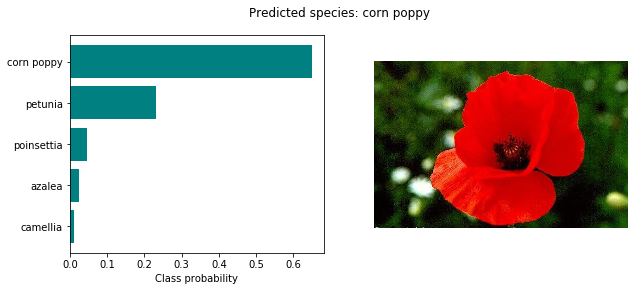

In [29]:
visualize("corn_poppy.jpg", "sample_images")

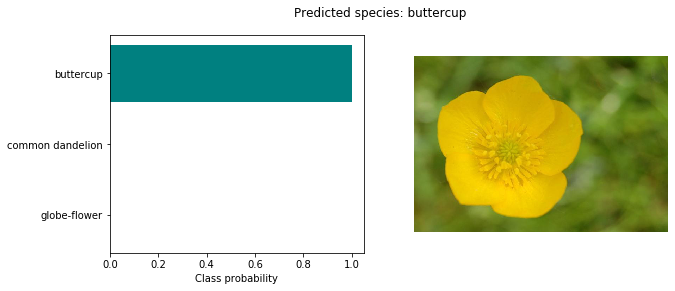

In [30]:
visualize("buttercup.jpg", "sample_images", topk=3)

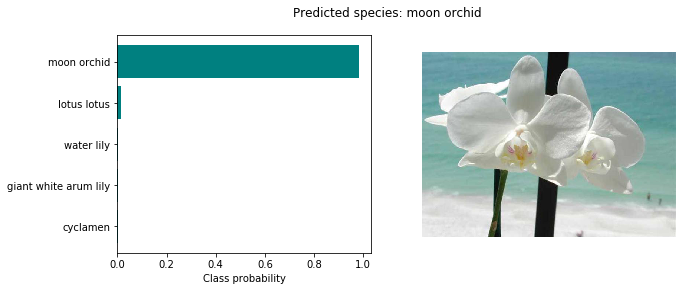

In [31]:
visualize("moon_orchid.jpg", "sample_images")

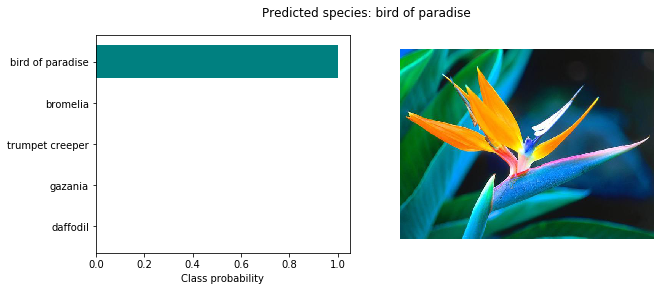

In [32]:
visualize("bird_of_paradise.jpg", "sample_images")